In [1]:
#import dependencies
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import scipy
import scipy.stats as stats
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from sklearn.cluster import KMeans

In [2]:
#upload data
business_data = pd.read_csv("Resources/yelp_business.csv")
business_hours_data = pd.read_csv("Resources/yelp_business_hours.csv")
check_in_data = pd.read_csv("Resources/yelp_checkin.csv")
review_data  = pd.read_csv("Resources/yelp_review.csv")
business_attributes_data = pd.read_csv("Resources/yelp_business_attributes.csv")
tip_data = pd.read_csv("Resources/yelp_tip.csv")
user_data = pd.read_csv("Resources/yelp_user.csv")

In [3]:
#check null values
business_data.isnull().sum().sort_values(ascending = False)

neighborhood    106552
postal_code        623
longitude            1
latitude             1
state                1
city                 1
categories           0
is_open              0
review_count         0
stars                0
address              0
name                 0
business_id          0
dtype: int64

In [4]:
#number of restaurants in each city from business_data
business_data.city.value_counts()

Las Vegas                      26775
Phoenix                        17213
Toronto                        17206
Charlotte                       8553
Scottsdale                      8228
Pittsburgh                      6355
Mesa                            5760
Montréal                        5709
Henderson                       4465
Tempe                           4263
Chandler                        3994
Edinburgh                       3868
Cleveland                       3322
Madison                         3213
Glendale                        3206
Gilbert                         3128
Mississauga                     2726
Stuttgart                       2000
Peoria                          1706
Markham                         1564
North Las Vegas                 1393
Champaign                       1195
Scarborough                     1095
North York                      1092
Surprise                        1018
Richmond Hill                    888
Concord                          864
B

In [5]:
review_data.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0


In [6]:
#adding name of the business
name_df = business_data[['business_id', 'name']]
name_df.head()

,business_id,name
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design"""
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon"""
2,KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle"""
3,8DShNS-LuFqpEWIp0HxijA,"""Sports Authority"""
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap"""


In [7]:
#merging dataframe of 5 businesses 
review_df = pd.merge(review_data, name_df, how = 'left', left_on = 'business_id', right_on = 'business_id')
review_df.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool,name
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0,"""Wilensky's"""
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0,"""Tuck Shop"""
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0,"""Lester's Deli"""
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0,"""Five Guys"""
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0,"""Maison Christian Faure"""


Text(0.5,1,'Top 20 Cities by Businesses Listed')

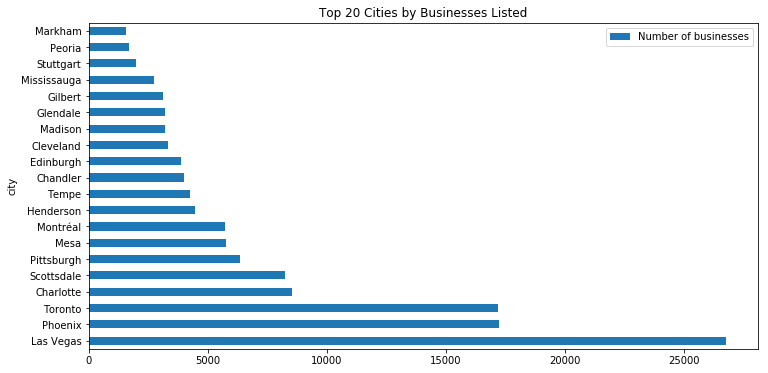

In [8]:
#bar graph for number of businesses in different cities 
city_business_counts = business_data[['city', 'business_id']].groupby(['city'])\
['business_id'].agg('count').sort_values(ascending=False)
city_business_counts = pd.DataFrame(data = city_business_counts)
city_business_counts.rename(columns={'business_id' : 'Number of businesses'}, inplace=True)

city_business_counts[0:20].sort_values(ascending=False, by="Number of businesses")\
.plot(kind='barh', stacked=False, figsize=[12,6])
plt.title('Top 20 Cities by Businesses Listed') 

In [9]:
#table of cities with most reviews and average ratings
city_business_reviews = business_data[['city', 'review_count', 'stars']].groupby(['city']).\
agg({'review_count': 'sum', 'stars': 'mean'}).sort_values(by='review_count', ascending=False)
city_business_reviews.head(10)

,review_count,stars
city,,
Las Vegas,1604173,3.709916
Phoenix,576709,3.673793
Toronto,430923,3.487272
Scottsdale,308529,3.948529
Charlotte,237115,3.571554
Pittsburgh,179471,3.629819
Henderson,166884,3.789362
Tempe,162772,3.729885
Mesa,130883,3.636024


In [10]:
# t-test of number of reviews from city business reviews and business data
stats.ttest_ind(city_business_reviews['review_count'], business_data['review_count'], equal_var = False)

Ttest_indResult(statistic=2.834935927335637, pvalue=0.004668011142103003)

In [11]:
# t-test of number of reviews from city business reviews and business data
stats.ttest_ind(city_business_reviews['stars'], business_data['stars'], equal_var = False)

Ttest_indResult(statistic=2.09312158301718, pvalue=0.0365626592797987)

Text(0.5,1,'Cities with greater than 100k reviews ranked by stars')

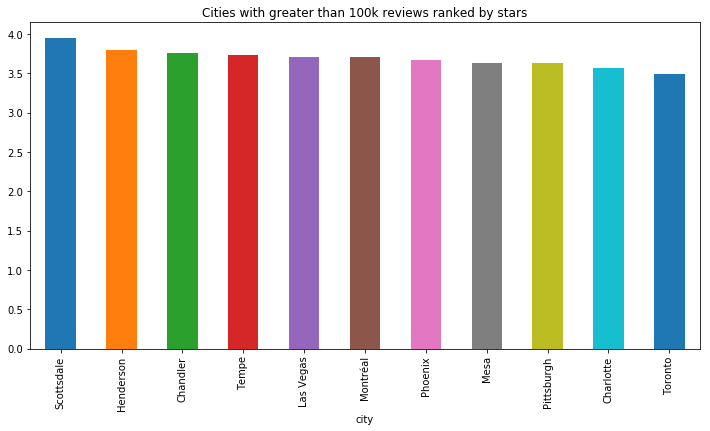

In [12]:
#bar graph of numbers of reviews for each city ranked by stars
city_business_reviews[city_business_reviews.review_count > 100000]['stars'].sort_values(ascending =False)\
.plot(kind='bar', stacked=False, figsize=[12,6])
plt.title('Cities with greater than 100k reviews ranked by stars')

There are 59106 different types/categories of businesses in Yelp!


Text(0.5,0,'Category')

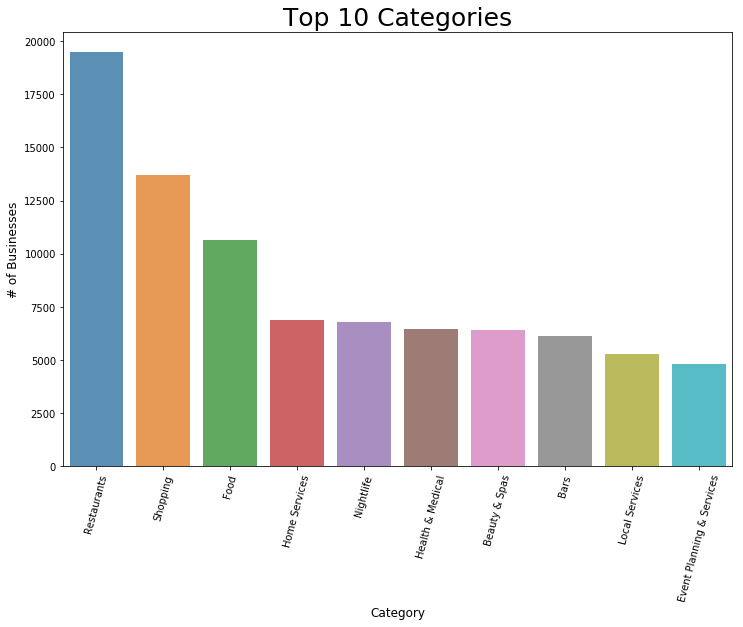

In [13]:
#bar graph of popular business categories
business_categories=' '.join(business_data['categories'])

categories=pd.DataFrame(business_categories.split(';'),columns=['category'])
x=categories.category.value_counts()
print("There are",len(x),"different types/categories of businesses in Yelp!")

x=x.sort_values(ascending=False)
x=x.iloc[0:10]

plt.figure(figsize=(12,8))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Top 10 Categories",fontsize=25)
locs, labels = plt.xticks()
plt.setp(labels, rotation=75)
plt.ylabel('# of Businesses', fontsize=12)
plt.xlabel('Category', fontsize=12)

In [14]:
#top 10 most reviewed businesses
business_data[['name', 'business_id','review_count','city','stars']].sort_values(ascending = False,by='review_count')[0:10]

,name,business_id,review_count,city,stars
97944,"""Mon Ami Gabi""",4JNXUYY8wbaaDmk3BPzlWw,7361,Las Vegas,4.0
119907,"""Bacchanal Buffet""",RESDUcs7fIiihp38-d6_6g,7009,Las Vegas,4.0
69993,"""Wicked Spoon""",K7lWdNUhCbcnEvI0NhGewg,5950,Las Vegas,3.5
81212,"""Gordon Ramsay BurGR""",cYwJA2A6I12KNkm2rtXd5g,5447,Las Vegas,4.0
139699,"""Earl of Sandwich""",DkYS3arLOhA8si5uUEmHOw,4869,Las Vegas,4.5
19191,"""Hash House A Go Go""",f4x1YBxkLrZg652xt2KR5g,4774,Las Vegas,4.0
80590,"""The Buffet""",2weQS-RnoOBhb1KsHKyoSQ,4018,Las Vegas,3.5
124412,"""Lotus of Siam""",KskYqH1Bi7Z_61pH6Om8pg,3964,Las Vegas,4.0
21006,"""Serendipity 3""",eoHdUeQDNgQ6WYEnP2aiRw,3910,Las Vegas,3.0
93038,"""The Buffet at Bellagio""",ujHiaprwCQ5ewziu0Vi9rw,3838,Las Vegas,3.5


In [15]:
#Tip data (specific popular words used in reviews)
selected_words = ['awesome', 'great', 'fantastic', 'amazing', 'love', 'horrible', 'bad', 'terrible', 
                  'awful',  'disappoint','hate']
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(vocabulary=selected_words, lowercase=False)
selected_word_count = vectorizer.fit_transform(tip_data['text'].values.astype('U'))
vectorizer.get_feature_names()

['awesome',
 'great',
 'fantastic',
 'amazing',
 'love',
 'horrible',
 'bad',
 'terrible',
 'awful',
 'disappoint',
 'hate']

Text(0.5,0,'Select Words from Reviews')

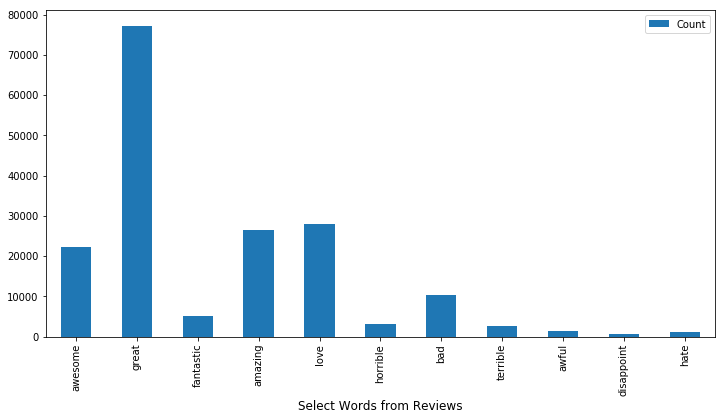

In [16]:
word_count_array = selected_word_count.toarray()
word_count_array.shape
word_count_array.sum(axis=0)
temp = pd.DataFrame(index=vectorizer.get_feature_names(), \
                    data=word_count_array.sum(axis=0)).rename(columns={0: 'Count'})
temp.plot(kind='bar', stacked=False, figsize=[12,6])
plt.xlabel('Select Words from Reviews', fontsize=12)

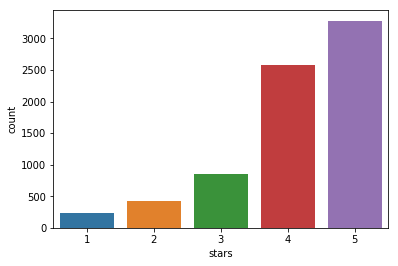

In [17]:
#number of reviews for each star rating for "Mon Ami Gabi" restaurant
bus_id = '4JNXUYY8wbaaDmk3BPzlWw'
company_df = review_df[review_df['business_id'] == bus_id]
sns.countplot(x = company_df['stars'])

In [18]:
#one restaurant with high star rating to see what the user tips look like
business_data[(business_data['city'] == 'Las Vegas') & (business_data['stars'] == 4.5)] 
business_data[(business_data['name'] == '"Mon Ami Gabi"')] #restaurant with many reviews

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
97944,4JNXUYY8wbaaDmk3BPzlWw,"""Mon Ami Gabi""",The Strip,"""3655 Las Vegas Blvd S""",Las Vegas,NV,89109,36.112827,-115.172581,4.0,7361,1,French;Steakhouses;Restaurants;Breakfast & Brunch


In [19]:
Mon_Ami_Gabi = tip_data[tip_data.business_id==business_data.loc[173518,:].business_id]
Mon_Ami_Gabi_selected_word_count = \
vectorizer.fit_transform(Mon_Ami_Gabi['text'].values.astype('U'))
word_count_array = Mon_Ami_Gabi_selected_word_count.toarray()
temp = pd.DataFrame(index=vectorizer.get_feature_names(), \
                    data=word_count_array.sum(axis=0)).rename(columns={0: 'Count'})
temp

,Count
awesome,0
great,4
fantastic,0
amazing,2
love,2
horrible,0
bad,0
terrible,0
awful,0
disappoint,0


In [20]:
#top least starred businesses
business_data[(business_data['city'] == 'Las Vegas') & (business_data['stars'] <=2.0) & (business_data['review_count'] > 20)][0:10]  
              

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
510,cJEFQQ828hvsTNUclWOx9w,"""Ultris Arrow Canyon""",NaN,"""5005 Losee Rd""",Las Vegas,NV,89081,36.252056,-115.118031,1.5,43,1,Home Services;Real Estate;Apartments
695,EEePiBwchl-TIBVcTdE0RA,"""McDonald's""",The Strip,"""Excalibur Food Court, 3850 Las Vegas Blvd S""",Las Vegas,NV,89119,36.098909,-115.175557,2.0,26,0,Burgers;Fast Food;Restaurants
845,84OaY6g32C6PiRXXd3suuw,"""ARCO ampm""",Spring Valley,"""7262 S Fort Apache Rd""",Las Vegas,NV,89178,36.055971,-115.297041,2.0,26,1,Gas Stations;Convenience Stores;Food;Automotive
1870,rfwJFFzW6xW2qYfJh14OTA,"""Sirens of Treasure Island""",The Strip,"""Treasure Island, 3300 Las Vegas Blvd S""",Las Vegas,NV,89109,36.124823,-115.171971,2.0,136,0,Performing Arts;Arts & Entertainment
1982,0PenhUhRbw2xd_suA68IjA,"""Soul2Soul Tim McGraw & Faith Hill""",Eastside,"""3355 Las Vegas Blvd S""",Las Vegas,NV,89109,36.124423,-115.146372,2.0,51,1,Arts & Entertainment;Nightlife;Music Venues
2346,6XJ4ddzEQ2GUQbLiXbgQ3Q,"""AT&T""",Southwest,"""4380 Blue Diamond Rd, Ste 101""",Las Vegas,NV,89139,36.037566,-115.198718,2.0,45,1,Mobile Phones;Shopping
2444,A1ZRCrjOMOwQGj2hCYWDEQ,"""KFC""",Summerlin,"""10267 W Charleston Blvd.""",Las Vegas,NV,89135,36.158800,-115.316000,1.5,38,1,Chicken Wings;Restaurants;Fast Food
2495,oL_fYqSHG63vR0TBMyoo_A,"""Green Leaf's & Bananas""",Downtown,"""875 S Grand Central Pkwy, Ste 1490""",Las Vegas,NV,89106,36.163691,-115.157758,2.0,23,1,Soup;Restaurants;Ice Cream & Frozen Yogurt;Foo...
3214,5qK5rJxwo0cjP3vTf3lkSA,"""Little Caesars Pizza""",Northwest,"""6621 W Cheyenne Ave""",Las Vegas,NV,89108,36.217802,-115.240624,1.5,24,1,Restaurants;Pizza
3450,HiqYus6muaBFlZtHhES7XQ,"""Del Taco""",Southwest,"""4800 W Cactus Ave""",Las Vegas,NV,89141,35.998741,-115.205507,2.0,24,1,Restaurants;Mexican;Fast Food


In [21]:
#one restaurant with low star rating to see what the user tips look like
business_data[(business_data['city'] == 'Las Vegas') & (business_data['stars'] == 1.0)] 
business_data[(business_data['name'] == '"Little Caesars Pizza"')] #restaurant with least reviews

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
80,kKx8iCJkomVQBdWHnmmOiA,"""Little Caesars Pizza""",NaN,"""10720 E Southern Ave""",Mesa,AZ,85209,33.394877,-111.600194,2.5,4,1,Restaurants;Pizza
524,D1E_6MBFKeU2a7EQ4IwoEQ,"""Little Caesars Pizza""",NaN,"""13011 W Greenway Blvd""",El Mirage,AZ,85335,33.623055,-112.339758,2.5,15,1,Restaurants;Pizza
805,VqF6Uky7SGfjWitgxrhlJA,"""Little Caesars Pizza""",NaN,"""6466 S Higley Rd""",Gilbert,AZ,85298,33.231942,-111.721218,4.0,9,1,Pizza;Restaurants
2274,Lvr6DdVkFI8IMGfRvUcXQA,"""Little Caesars Pizza""",NaN,"""4340 W McDowell Rd, Ste 6""",Phoenix,AZ,85035,33.466332,-112.153483,1.0,3,1,Pizza;Restaurants
3214,5qK5rJxwo0cjP3vTf3lkSA,"""Little Caesars Pizza""",Northwest,"""6621 W Cheyenne Ave""",Las Vegas,NV,89108,36.217802,-115.240624,1.5,24,1,Restaurants;Pizza
5500,xrpZFPRMf5WVgVXT5uuJ6Q,"""Little Caesars Pizza""",NaN,"""911 S Lindsay Rd""",Gilbert,AZ,85296,33.333727,-111.771796,3.0,8,1,Pizza;Restaurants
7601,77FYW55qBiRAMZRxdIKApA,"""Little Caesars Pizza""",NaN,"""8929 N Central Ave""",Phoenix,AZ,85020,33.567062,-112.073449,3.0,8,1,Restaurants;Pizza
10046,a4u2xhZQ8KXLPeGkoPdNOg,"""Little Caesars Pizza""",NaN,"""4315 Boul Saint-Jean""",Dollard-des-Ormeaux,QC,H9H 2A4,45.480618,-73.842224,2.0,4,1,Restaurants;Pizza
12913,H1LhTQWW_YCgJejzBSOFBw,"""Little Caesars Pizza""",NaN,"""613 Highland St""",Mount Holly,NC,28120,35.287801,-81.017618,1.0,3,1,Restaurants;Pizza
13805,zrKalMnWJY-lkl2KeQTelQ,"""Little Caesars Pizza""",NaN,"""2950 N 32nd St""",Phoenix,AZ,85018,33.482065,-112.013273,3.0,6,1,Restaurants;Pizza


In [22]:
Little_Caesars_Pizza = tip_data[tip_data.business_id==business_data.loc[36284,:].business_id]
Little_Caesars_Pizza_selected_word_count = \
vectorizer.fit_transform(Little_Caesars_Pizza['text'].values.astype('U'))
word_count_array = Little_Caesars_Pizza_selected_word_count.toarray()
temp = pd.DataFrame(index=vectorizer.get_feature_names(), \
                    data=word_count_array.sum(axis=0)).rename(columns={0: 'Count'})
temp
#people refer to write a good part of the review rather than the bad part of the review unless they are furious

,Count
awesome,0
great,0
fantastic,0
amazing,0
love,0
horrible,0
bad,1
terrible,0
awful,0
disappoint,0
